In [1]:
from parcels import (
    FieldSet,
    ParticleSet,
    Variable,
    JITParticle,
    AdvectionRK4_3D,
    DiffusionUniformKh,
)
from parcels import StatusCode
from glob import glob
from datetime import timedelta
import numpy as np
from scipy import interpolate
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import os

In [2]:
# read input data from Init yaml file

with open("Init.yaml", "r") as file:


    Init = yaml.safe_load(file)

In [3]:
# define output folder

output_path = Init["parcels_data_path"]
if not os.path.exists(output_path):
    os.makedirs(output_path)


# retrieve ocean currents data and respective mesh and put them in lists of files (ufiles, vfiles, wfiles)


data_path = Init["ocean_data_path"]


ufiles = sorted(glob(data_path + "rea*U.nc"))


vfiles = sorted(glob(data_path + "rea*V.nc"))


wfiles = sorted(glob(data_path + "rea*W.nc"))


mesh_mask = data_path + "mesh_mask.nc"

In [4]:
# define which files are going to be read according to the variable to be considered

filenames = {
    "U": {"lon": mesh_mask, "lat": mesh_mask, "depth": wfiles[0], "data": ufiles},
    "V": {"lon": mesh_mask, "lat": mesh_mask, "depth": wfiles[0], "data": vfiles},
    "W": {"lon": mesh_mask, "lat": mesh_mask, "depth": wfiles[0], "data": wfiles},
}

# define the variables, which are read from data (ufiles, vfiles, wfiles)

variables = {"U": "vozocrtx", "V": "vomecrty", "W": "vovecrtz"}

# define the dimensions: lon, lat (from glamf, gphif in mesh_mask), depth (from depthw in wfiles[0]) and time (from time_counter in ufiles)

dimensions = {
    "U": {"lon": "glamf", "lat": "gphif", "depth": "depthw", "time": "time_counter"},
    "V": {"lon": "glamf", "lat": "gphif", "depth": "depthw", "time": "time_counter"},
    "W": {"lon": "glamf", "lat": "gphif", "depth": "depthw", "time": "time_counter"},
}

In [5]:
# define the fieldset using FieldSet and data from Nemo

fieldset = FieldSet.from_nemo(filenames, variables, dimensions)

In [6]:
# Add constant field K diffusivity from DeDominicis 2013 [m^2 s^-1]

fieldset.add_constant_field("Kh_zonal", 10, mesh="spherical")
fieldset.add_constant_field("Kh_meridional", 10, mesh="spherical")

In [7]:
# Define the buoyant velocity Kernel


def BuoyantVel(particle, fieldset, time):

    new_depth = particle.depth + particle.w_buoy * particle.dt

    if new_depth > 0:

        particle.depth = new_depth

    else:

        particle.depth = 0.0

In [8]:
def KeepInOcean(particle, fieldset, time):
    if particle.state == StatusCode.ErrorThroughSurface:
        particle.depth = 0.0
        particle.state = StatusCode.Success

In [9]:
def DeleteErrorParticle(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:
        particle.delete()

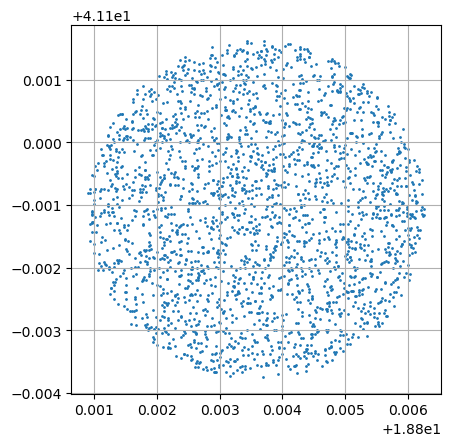

In [10]:
# Initial position of the far-field parcels (from the final position of the near-field region)

npart = Init["npart"]


init_lon = Init["init_lon"]

init_lat = Init["init_lat"]


# near-field region defines the initial location and extension of the far-field spill


Dlat_plume = Init["Dlat_plume"] / 111111  # Delta y / 111 km


Dlon_plume = Init["Dlon_plume"] / (
    111111 * np.cos(init_lat * np.pi / 180)
)  # Delta x / (111 km * cos lat)


init_lat += Dlat_plume
init_lon += Dlon_plume


final_radius = Init[
    "final_radius"
]  # final radius of plume model is 300 m / 111 111 m = 0.0027 degrees


# parcels are randomly displaced within the defined shape


radial_distances = np.sqrt(np.random.uniform(0, 1, npart)) * final_radius

angles = np.random.uniform(0, 2 * np.pi, npart)


# Convert polar coordinates to Cartesian coordinates


lon = init_lon + radial_distances * np.cos(angles)

lat = init_lat + radial_distances * np.sin(angles)


# Plot the parcels horizontal space distribution


plt.grid()


plt.scatter(lon, lat, s=1)  # s controls the marker size


plt.gca().set_aspect(
    "equal", adjustable="box"
)  # Equal aspect ratio for a circular plot


plt.show()

# Define initial depth


init_depth = Init["init_depth"]


# Define release time (after first available ocean data date)


# to do instant release:


t0 = timedelta(days=Init["release_delay"], hours=0, minutes=0).total_seconds()  # release time


time = t0


# to do continuous release:


# repeatdt = timedelta(hours=24)


# time = t0 + np.arange(0, npart) * timedelta(seconds=1).total_seconds()

In [11]:
# Assign each particle a buoyant velocity, depending on size PDF built in w_buoy.csv

wb_df = pd.read_csv(
    Init["wbuoy_data_path"],
    sep="\t",
    usecols=["Diam (mm)", "w_buoy (m/s)", "Frequency"],
)


pdf = wb_df["Frequency"].values


pdf = pdf / np.sum(pdf)


w_buoy = np.zeros(npart)


diam = np.zeros(npart)


for n in range(npart):

    index = np.searchsorted(pdf.cumsum(), np.random.rand())

    w_buoy[n] = wb_df["w_buoy (m/s)"].iloc[index]

    diam[n] = wb_df["Diam (mm)"].iloc[index]

assert len(w_buoy) == npart

w_buoy

array([-0.0595, -0.0864, -0.1477, ..., -0.0329, -0.1385, -0.1347],
      shape=(2500,))

In [12]:
# define a ParticleSet from the inherit class BuoyParticle


class BuoyParticle(JITParticle):

    w_buoy = Variable("w_buoy", initial=0.0)


# define particle set


pset = ParticleSet(
    fieldset=fieldset,
    pclass=BuoyParticle,
    lon=lon,
    lat=lat,
    time=time,
    depth=init_depth * np.ones(npart),
    w_buoy=w_buoy,
)

In [13]:
kernels = (
    AdvectionRK4_3D
    + pset.Kernel(DiffusionUniformKh)
    + pset.Kernel(DeleteErrorParticle)
    + pset.Kernel(KeepInOcean)
    + pset.Kernel(BuoyantVel)
)

In [14]:
# define simulation time periods and intervals

# output time- interval


output_dt = Init["output_dt"]  # minutes


output_file = pset.ParticleFile(
    name=output_path,
    outputdt=timedelta(minutes=output_dt),
)

# Simulation time and numerical dt


pset.execute(
    kernels,
    runtime=timedelta(hours=Init["sim_runtime"]),
    dt=timedelta(minutes=Init["sim_dt"]),
    output_file=output_file,
)

INFO: Output files are stored in ./parcels.zarr.
100%|██████████| 43200.0/43200.0 [01:22<00:00, 523.50it/s]
